<img src="../Pics/MLSb-T.png" width="160">
<br><br>
<center><u><H1>Logistic Regression with TensorFlow</H1></u></center>

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
%matplotlib inline

In [2]:
tf.__version__

'1.8.0'

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
#The MNIST data-set will be downloaded automatically if it is not located in the given path.
data = input_data.read_data_sets("data/MNIST/", one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data/MNIST/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [4]:
print("Size of:")
print("- Training-set:\t\t{}".format(len(data.train.labels)))
print("- Test-set:\t\t{}".format(len(data.test.labels)))
print("- Validation-set:\t{}".format(len(data.validation.labels)))

Size of:
- Training-set:		55000
- Test-set:		10000
- Validation-set:	5000


In [5]:
#One hot encoding
data.test.labels[0:5, :]

array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]])

In [6]:
#Converting one hot encoding to class numbers
data.test.cls = np.array([label.argmax() for label in data.test.labels])

In [7]:
data.test.cls[0:5]

array([7, 2, 1, 0, 4], dtype=int64)

### Data Dimensions:

In [8]:
# MNIST images are 28 x 28 pixels.
img_size = 28

# Images are stored in one-dimensional (flatten) arrays of this length.
img_size_flat = img_size * img_size

# Tuple with height and width of images used to reshape arrays.
img_shape = (img_size, img_size)

# Number of classes, one class for each of 10 digits.
n_classes = 10

In [9]:
# Let's create a function used to plot 10 images in a 1x10 grid, and writing the true and predicted classes below each image

def plot_img(images, cls_label, cls_pred=None):
    
    # Creating a figure with 1x10 sub plots.
    fig, axes = plt.subplots(1, 10, figsize=(15,15))
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for idx, ax in enumerate(axes.flat):
        # plot the image.
        ax.imshow(images[idx].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_label[idx]) # shows only the class label
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_label[idx], cls_pred[idx])

        ax.set_xlabel(xlabel)
        ax.set_xticks([])
        ax.set_yticks([])
        
    plt.show()

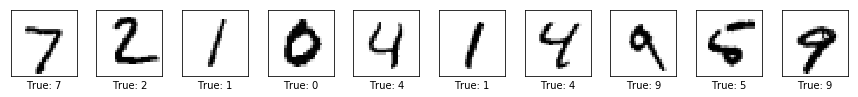

In [11]:
# Get the first images from the test-set.
images = data.test.images[0:10]

# Get the true classes for those images.
cls_label = data.test.cls[0:10]

# Plot the images and labels using our helper-function above.
plot_img(images=images, cls_label=cls_label)

In [12]:
#Placeholder variables serve as the input to the graph that we may change each time we execute the graph
x = tf.placeholder(tf.float32, [None, img_size_flat])
y_true = tf.placeholder(tf.float32, [None, n_classes])

In [13]:
y_true_cls = tf.placeholder(tf.int64, [None])

In [14]:
# there are also some model variables that must be changed by TensorFlow 
# so as to make the model perform better on the training data.
weights = tf.Variable(tf.zeros([img_size_flat, n_classes]))
biases = tf.Variable(tf.zeros([n_classes]))

## Model:

In [15]:
model = tf.matmul(x, weights) + biases

In [16]:
# Normalization of the output. Each row of the model matrix sums to one, and each element is limited between zero and one.
y_pred = tf.nn.softmax(model)

In [17]:
# The predicted class can be calculated from the y_pred matrix by taking the index of the largest element in each row.
y_pred_cls = tf.argmax(y_pred, axis=1)

## Cost Function:

In [18]:
#Cross entropy error function for classification
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=model,labels=y_true)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



In [19]:
# In order to use the cross-entropy to guide the optimization of the model's variables we need a single scalar value,
# so we simply take the average of the cross-entropy for all the image classifications.
cost = tf.reduce_mean(cross_entropy)

## Optimization method:

In [20]:
# gradient descent
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.5).minimize(cost)

## Performance Measures:

In [21]:
# Let's create a vector of booleans whether the predicted class equals the true class of each image
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

In [22]:
# Caluclating the accuracy: first type-casting the vector of booleans to floats, so that False becomes 0 and True becomes 1,
# and then calculating the average of these numbers.
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

## TensorFlow session

In [23]:
#we have to create a TensorFlow session which is used to execute the graph
session = tf.Session()

In [24]:
# The variables for weights and biases must be initialized before we start optimizing them.
session.run(tf.global_variables_initializer())

In [25]:
batch_size = 100

In [26]:
def optimize(num_iterations):
    for i in range(num_iterations):
        # Get a batch of training examples.
        # x_batch now holds a batch of images and
        # y_true_batch are the true labels for those images.
        x_batch, y_true_batch = data.train.next_batch(batch_size)
        
        # Put the batch into a dict with the proper names
        # for placeholder variables in the TensorFlow graph.
        # Note that the placeholder for y_true_cls is not set
        # because it is not used during training.
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}

        # Run the optimizer using this batch of training data.
        # TensorFlow assigns the variables in feed_dict_train
        # to the placeholder variables and then runs the optimizer.
        session.run(optimizer, feed_dict=feed_dict_train)

In [27]:
# feed with test data
feed_dict_test = {x: data.test.images,
                  y_true: data.test.labels,
                  y_true_cls: data.test.cls}

In [28]:
#Function for printing the classification accuracy on the test-set.
def print_accuracy():
    acc = session.run(accuracy, feed_dict=feed_dict_test)
    print("Accuracy on test-set: {0:.1%}".format(acc))

In [29]:
def print_confusion_matrix():
    # Get the true classifications for the test-set.
    label_true = data.test.cls
    
    # predicted labels for the test-set.
    label_pred = session.run(y_pred_cls, feed_dict=feed_dict_test)

    cm = confusion_matrix(y_true=label_true,
                          y_pred=label_pred)

    print(cm)

    # Plot the confusion matrix as an image.
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.afmhot)

    plt.tight_layout()
    plt.colorbar()
    tick_marks = np.arange(n_classes)
    plt.xticks(tick_marks, range(n_classes))
    plt.yticks(tick_marks, range(n_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [30]:
#Function for plotting examples of images from the test-set that have been mis-classified.
def plot_example_errors():
    # Use TensorFlow to get a list of boolean values
    # whether each test-image has been correctly classified,
    # and a list for the predicted class of each image.
    correct, cls_pred = session.run([correct_prediction, y_pred_cls],
                                    feed_dict=feed_dict_test)

    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = data.test.images[incorrect]
    
    # Get the predicted classes for those images.
    label_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    label_true = data.test.cls[incorrect]
    
    # Plot the first 10 images.
    plot_img(images=images[0:10],
                cls_label=label_true[0:10],
                cls_pred=label_pred[0:10])

## Performance before optimization

In [31]:
print_accuracy()

Accuracy on test-set: 9.8%


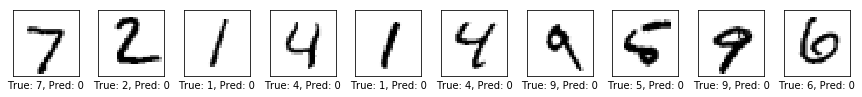

In [32]:
plot_example_errors()

## Performance after 10 optimization iterations

In [33]:
optimize(num_iterations=10)

In [34]:
print_accuracy()

Accuracy on test-set: 78.6%


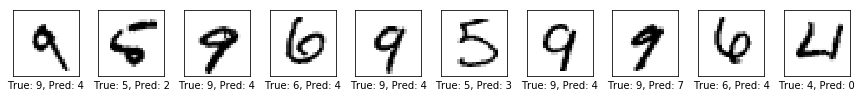

In [35]:
plot_example_errors()

## Performance after 1000 optimization iterations

In [36]:
# We have already performed 10 iterations.
optimize(num_iterations=990)

In [37]:
print_accuracy()

Accuracy on test-set: 91.6%


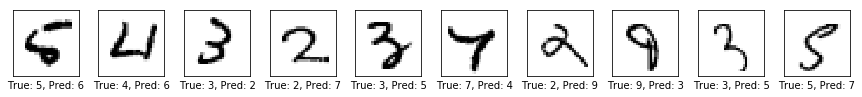

In [38]:
plot_example_errors()

[[ 956    0    2    1    0    7   11    1    2    0]
 [   0 1117    2    2    0    2    4    2    6    0]
 [   6   14  918   16    8    5   15   13   31    6]
 [   3    1   17  894    0   55    4   16   14    6]
 [   1    4    4    1  905    0   16    3    8   40]
 [  10    4    4   20    7  786   20    8   26    7]
 [   9    3    3    2    9   13  916    1    2    0]
 [   3   14   22    7    6    1    0  953    2   20]
 [   8   16    8   26    8   37   14   15  832   10]
 [  11    8    1   11   36    8    1   39    6  888]]


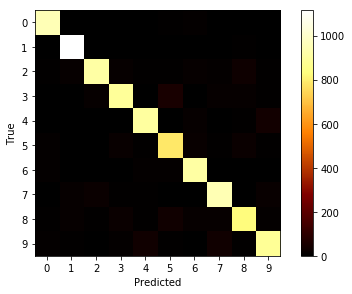

In [39]:
print_confusion_matrix()

In [40]:
session.close()

## Reference:

https://www.tensorflow.org/tutorials/wide